In [ ]:
%pip install webdriver-manager

In [1]:
import pandas as pd
import numpy as np
import openpyxl
from selenium import webdriver
import requests as req
from bs4 import BeautifulSoup as bs
import json
import re
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time

import warnings   # para quitar warnings
warnings.simplefilter('ignore')

In [2]:
from src.functions import *

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

## 🥷WEB SCRPING - INE

Abrir la ventana nueva para hacer el scrapping

In [39]:
from webdriver_manager.chrome import ChromeDriverManager
driver = webdriver.Chrome(ChromeDriverManager().install())



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [/Users/marilyngutierrez/.wdm/drivers/chromedriver/mac64/97.0.4692.71/chromedriver] found in cache


Url de donde extraigo los datos

In [40]:
driver.get("https://www.ine.es/")

Buscar el input / Click en el buscador / Esperar 2 segundos para escribir / Escribir la palabra que quiero buscar

In [41]:
escribir = driver.find_element_by_xpath('//input[@id="searchString"]')
escribir.click()
time.sleep(2)
escribir.send_keys('tabaco')

Seleccionar el botón lupa para buscar / Hacer click para buscar

In [42]:
buscar = driver.find_element_by_xpath('//button[@id="Menu_botonBuscador"]')
buscar.click()

Selecciono el primer enlace

In [43]:
enlace = driver.find_element_by_xpath('//*[@id="tabsResult"]/ul/li[1]/ul/li[1]/a/span[3]')
enlace.click()

Cambia a la venta nueva que se ha abierto y espera dos segundos

In [44]:
driver.switch_to.window(driver.window_handles[1])
time.sleep(2)

Acepta las cookies para quitar ese cuadro de diálogo

In [45]:
cookies = driver.find_element_by_xpath('//*[@id="aceptarCookie"]')
cookies.click()

Click en botón para visualizar tabla

In [46]:
verTabla = driver.find_element_by_xpath('//*[@id="botonConsulSele"]')
verTabla.click()

In [ ]:
#Volver a la ventana principal
#driver.switch_to.window(driver.window_handles[0])

Extraer la tabla, solo trae el esquema no los datos

In [47]:
tabla=driver.find_element_by_tag_name('tbody')
filas=tabla.find_elements_by_tag_name('tr')

Se realizan bucles para traer todos los datos

In [48]:
data=[[e.text for e in f.find_elements_by_tag_name('td')] for f in filas]
cabeceras=driver.find_element_by_tag_name('thead')
cabeceras=[c.text for c in cabeceras.find_elements_by_tag_name('th')]

#driver.quit()

Convertir la tabla en dataframe para trabajar con ella

In [49]:
tablaCompleta = pd.DataFrame(data)
#tablaCompleta

La tabla tiene celdas combinadas, así que se pierden los títulos, pasádole un diccionario se vuelven a redefinir

In [50]:
tabla_Completa = tablaCompleta.rename(columns={0:'Porcentaje_Pandemia',
                                   1:'Fumador_Diario_Pandemia',
                                2:'Fumador_Ocasional_Pandemia',
                                3:'No_Fumador_Pandemia',
                                4:'Porcentaje_Antes',
                                5:'Fumador_Diario_Antes',
                                6:'Fumador_Ocasional_Antes',
                                7:'No_Fumador_Antes'})

tabla_Completa.columns

Index(['Porcentaje_Pandemia', 'Fumador_Diario_Pandemia',
       'Fumador_Ocasional_Pandemia', 'No_Fumador_Pandemia', 'Porcentaje_Antes',
       'Fumador_Diario_Antes', 'Fumador_Ocasional_Antes', 'No_Fumador_Antes'],
      dtype='object')

Añade nueva columna con los nombres de los grupos de datos

In [51]:
tabla_Completa.insert(0,"Grupos",['Ambos','Total1','15-44A','45-54A','65+A','Hombres','Total2','15-44H','45-54H','65+H','Mujeres','Total3','15-44M','45-54M','65+M'],True)

In [ ]:
#tabla_Completa

Borra las filas que no son necesarias

In [52]:
tabla_Completa.drop([0,5,6,7,8,9,10,11,12,13,14],axis=0, inplace=True)

Cambiar el índice por los nombres de los grupos y elimina el índice por defecto

In [53]:
tabla_Completa.set_index('Grupos', drop=True, inplace=True, verify_integrity=True)

### Visualizaciones

Guardar en formato JSON la tabla

In [ ]:
tabla_Completa.to_json("data/grupos.json", orient = 'columns')

Función definida en el archivo 'src/functions.py'

In [ ]:
#scraping()⚠️ No funciona llamándola desde el archivo de funciones

##  📂UTILIZACIÓN DE ARCHIVOS CSV

In [ ]:
#_____ NO LO UTILIZO - APUNTES PARA ARCHIVOS EXCEL ________________________________

#Traer el archivo
#excel = pd.ExcelFile('data/2018-2019_Comunidades euros.xlsx')
#Ver las hojas que tiene el archivo
#excel.sheet_names
#Visualizar la hoja en cuestión
#excel.parse('Hoja1')

Traer CSV, la separación puede ser por comas o punto y coma. 
#### AÑOS 2018 Y 2019 - ANTES DE LA PANDEMIA

Función para convertir la columna de datos totales de tipo object a tipo int y poder operar con ella

In [4]:
def cambiar(i):
    x = i.replace('.','')
    return int(x)

In [5]:
csv1 = pd.read_csv('data/2018-2019_Comunidades euros.csv', sep=';')
#csv1

Borra las columnas que no son necesarias

In [6]:
new_one = csv1.drop(['CIGARRILLOS2019','CIGARROS2019','P. LIAR2019','P. PIPA2019','CIGARRILLOS2018','CIGARROS2018','P. LIAR2018','P. PIPA2018'],axis=1)
#new_one

Reemplaza la columna object por la columna int pasándole la función definida al inicio de este bloque csv

In [7]:
new_one['TOTALES2019'] = new_one['TOTALES2019'].apply(cambiar)

In [8]:
new_one['TOTALES2018'] = new_one['TOTALES2018'].apply(cambiar)

In [ ]:
#new_one

#### AÑOS 2020 Y 2021 - DURANTE LA PANDEMIA

In [9]:
csv2 = pd.read_csv('data/2020-2021_Comunidades-euros.csv', sep=';')

Borra las columnas que no son necesarias

In [10]:
new_two = csv2.drop(['CIGARRILLOS2021','CIGARROS2021','P. LIAR2021','P. PIPA2021','CIGARRILLOS2020','CIGARROS2020','P. LIAR2020','P. PIPA2020'],axis=1)
#new_two

Reemplaza la columna object por la columna int pasándole la función definida al inicio de este bloque csv

In [11]:
new_two['TOTALES2021'] = new_two['TOTALES2021'].apply(cambiar)

Reemplaza la columna object por la columna int pasándole la función definida al inicio de este bloque csv

In [12]:
new_two['TOTALES2020'] = new_two['TOTALES2020'].apply(cambiar)
#new_two

Juntar en un mismo dataframe las facturaciones de las CCAA por años

In [13]:
new_one.insert(1, "TOTALES2020", new_two['TOTALES2020'])

In [14]:
new_one.insert(1, "TOTALES2021", new_two['TOTALES2021'])

Añade columna de id para mejor manejo en BBDD

In [ ]:
new_one.insert(0, "id", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

In [15]:
new_one

,COMUNIDAD,TOTALES2021,TOTALES2020,TOTALES2019,TOTALES2018
0,Andalucía,1906290653,1842203340,1902995948,1839657868
1,Aragón,350321393,352976234,367348652,368119456
2,Asturias (Principado de),260145753,263785771,270830551,278186850
3,Balears (Illes),346027976,309911470,473864186,478575572
4,Cantabria,152536342,152539316,159280394,161665199
5,Castilla y León,594314364,588445139,613657789,622572271
6,Castilla-La Mancha,529011574,520539057,525047442,521695856
7,Cataluña,2248130696,2132069196,2317438514,2264274637
8,Comunidad Valenciana,1315762076,1321926472,1475664086,1465219502
9,Extremadura,269927208,267065029,274857399,274217775


Totalizar cada una de las columnas

In [ ]:
uno = new_one['TOTALES2021'].sum()
cero = new_one['TOTALES2020'].sum()
nueve = new_one['TOTALES2019'].sum()
ocho = new_one['TOTALES2018'].sum()

Crear una nueva fila que contenga los totales por años

In [ ]:
new_one.loc[16]=[16,'TotalCCAA', uno, cero,nueve,ocho]

In [ ]:
new_one

Guardar el dataframe en json para almacenar en BBDD (utilizado Mongo)

In [ ]:
new_one.to_json("data/new_one.json", orient = 'records')

### Visualización

Se hace la visualización antes de totalizar cada uno de los años

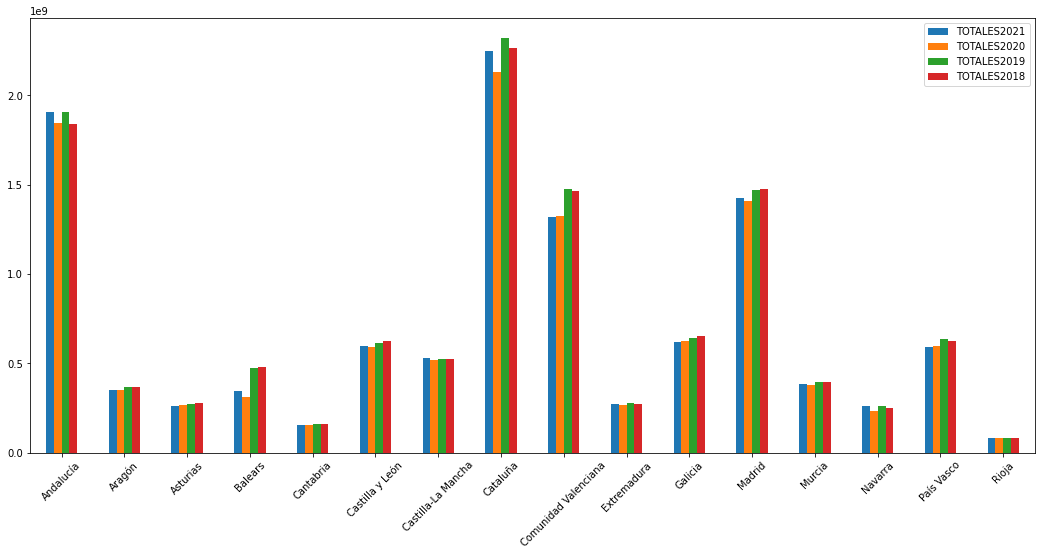

In [36]:
xlabels = ['Andalucía','Aragón','Asturias','Balears','Cantabria','Castilla y León','Castilla-La Mancha','Cataluña','Comunidad Valenciana','Extremadura','Galicia','Madrid','Murcia','Navarra','País Vasco','Rioja']
graphic = new_one.iloc[0:].plot.bar(figsize=(18,8));

graphic.set_xticklabels(xlabels, rotation=45);


## 💰 UTILIZACIÓN DE API - AFILIACIÓN S.S.

Llamo a la función definida en el archivo de 'src/functions.py'

In [ ]:
datos()

Conversión a dataframe

In [ ]:
afiliados = pd.DataFrame(datos(),index=[0])
#afiliados

Hace una media de los tres años para obtener datos del 2021. Inserta la nueva columna en la primera posición

In [ ]:
afiliados.insert(0,"2021",round(afiliados.iloc[0].mean(),1),True)

In [ ]:
afiliados

Guardar el dataframe en formato json

In [ ]:
afiliados.to_json("data/afiliados.json", orient = 'columns')

In [37]:
datos = pd.read_json("data/afiliados.json", orient='records')
datos

,2021,2020,2019,2018
0,22855.7,22733.3,23027.1,22806.8


### Visualización

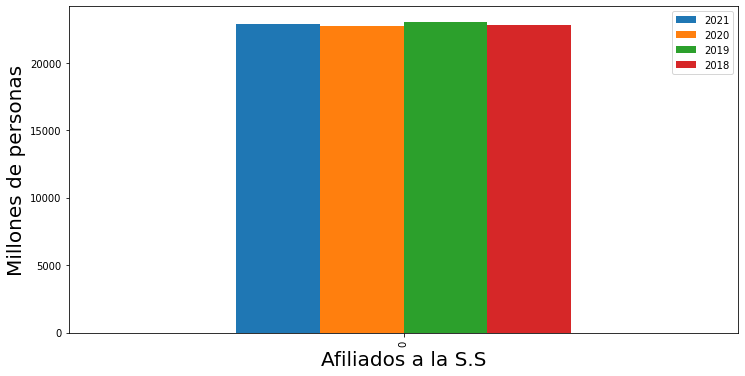

In [38]:
datos.plot(kind = 'bar', figsize=(12,6));

plt.xlabel('Afiliados a la S.S', size=20)
plt.ylabel('Millones de personas',size=20);